# Fix miss matched ions

## Content
1. Load modules
2. Import data
3. Identify highly similar peaks (mass_diff < 0.001, rt_diff < 0.085)
4. Investigate characteristics of merging candidates
5. Filter based on selected criteria and merge peaks accordingly
6. Get overall metrics of merged peaks (row completeness, correlation to manually extracted data)

## 1. Load modules

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
import scipy.stats as stats
import random
from datetime import date

import matplotlib
from matplotlib import cm
from matplotlib import colors

import multiprocessing as mp
#import time 

In [2]:
# define date for saving figures
today = date.today().strftime("%Y-%m-%d") # for saving files
# set number of columns to show when display is called
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

## 2. Import data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

In [ ]:
# Load tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

In [ ]:
targeted_ms_paths = glob.glob(\
    'intermed_results/01_noBadInjections/data/targeted_per_strain/*_input_targeted_*')
targeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                      for file in targeted_ms_paths]

In [ ]:
untargeted_ms_paths = glob.glob(\
    'intermed_results/01_noBadInjections/data/untargeted_per_strain/*_input_untargeted_*')
untargeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in untargeted_ms_paths]
    

del(targeted_ms_paths, untargeted_ms_paths)

## 3. Identify highly similar peaks (mass_diff < 0.001, rt_diff < 0.085)

Run clustering

In [8]:
per_strain_table = untargeted_perS_list # untargeted_perS_list
merge_candidate_clusters = []
per_strain_incl_clusID = []
row_count_dicts = [] # number of rows in each cluster
clus_size_dicts = [] # number of clusters with certain size

rt_thresh = 0.085

for k in range(len(per_strain_table): 
    
    #k = 76
    print('processing strain',k, 'of', len(per_strain_table))
    
    #select table
    table = per_strain_table[k].copy()
    
    #sort by mass
    table = table.sort_values(by='Mass')
    
    # add cluster column and assign mass clusters
    #------------
    cluster_col = []
    cluster = 0  # set 0 for first cluster
    mass_idx = table.columns.get_loc('Mass')
    ref_mass = table.iloc[0, mass_idx]
    
    for i in range(table.shape[0]):
        
        
        test_mass = table.iloc[i, mass_idx]
        
        expr1 = abs(test_mass-ref_mass) <= 0.001
        expr2 = (abs(test_mass-ref_mass)) <= (0.000002*test_mass)
        
        if not (expr1 or expr2):
            cluster = cluster+1
        
        cluster_col.append(str(cluster).zfill(6))
        ref_mass = test_mass
    
        
    table['cluster_id'] = cluster_col
    
    
    # for each cluster: sort for rt and split if rt varies more than 0.085
    #------------
    
    cluster_ids = sorted(list(set(cluster_col)))
    
    for j in range(len(cluster_ids)):
        
        if j % 1000 == 0:
            print( j,'of', len(cluster_ids), '(RT clustering) done')
        
        c = cluster_ids[j]
        
        subset = table.loc[table['cluster_id'] == c].copy()
        subset = subset.sort_values(by = 'RT', axis = 0)
        
        orig_clus_ids = list(subset['cluster_id'].copy())
        RT_idx = table.columns.get_loc('RT')
        ref_rt = subset.iloc[0,RT_idx]
        p = 0
        
        for i in range(subset.shape[0]):
        
            test_rt = subset.iloc[i, RT_idx]
            
            if (test_rt-ref_rt) >= rt_thresh:
                p = p+1
                orig_clus_ids[i] = orig_clus_ids[i]+'_'+str(p)
            else:
                orig_clus_ids[i] = orig_clus_ids[i]+'_'+str(p)
            
            ref_rt = test_rt
            
        # get back order from prior to sorting!!!
        #subset['cluster_id'] = orig_clus_ids
        
        table.loc[subset.index, 'cluster_id'] = orig_clus_ids
               
    
    # split clusters that don't share at least 2 ionization side products in comp-spectrum
    #------------
    
    cluster_col = table['cluster_id']
    
    cluster_ids = sorted(list(set(cluster_col)))
    

    for j in range(len(cluster_ids)):
        
        if j % 1000 == 0:
            print( j,'of',len(cluster_ids), '(CompSpec clustering) done')
        
        c = cluster_ids[j]
            
        subset = table.loc[table['cluster_id'] == c].copy()

        comp_spectra_list = []
        for comp in range(len(subset)):
            
            comp_idx = subset.index[comp]
            comp_spectra = subset.loc[comp_idx,'CompSpectrum']
            
            comp_spectra = comp_spectra.replace(')(', ');(')
            
            peak_list = comp_spectra.split(';')
            peak_list = [eval(e) for e in peak_list] #reformat to tuples
            
            peak_list_sort = sorted(peak_list, key = lambda x: x[1], reverse = True)
    
            comp_spectra_list.append(peak_list_sort)
        
        
        subset['CompSpectrum'] = comp_spectra_list
        
        if subset.shape[0] > 1:
        
            #initialise matrix
            sim_matrix = pd.DataFrame(0, index = range(len(comp_spectra_list)),\
                                      columns = range(len(comp_spectra_list)))
            
            for comp_id in range(len(comp_spectra_list)):
                #comp_id = 33 #testing
                for match_id in [i for i in range(len(comp_spectra_list)) \
                                 if not i == comp_id]:
                    
                    # test for matching ions
                    #match_id = 5 #testing
                    comps_1 = [x[0] for x in comp_spectra_list[comp_id]]
                    comps_2 = [x[0] for x in comp_spectra_list[match_id]]
                    # get number of matches
                    n = 0
                    for mass in comps_1:
                        #mass = top3_comp[2] #testing
                        
                        if any([True for t in comps_2 if ((t > mass-0.001 and \
                                t < mass+0.001) or (t > mass-mass*0.000002 and \
                                t < mass+mass*0.000002) )]):
                            n = n+1
                     
                   # create distance matrix considering comp.-spectrum. RT and mass difference
                   #--------------
                   
                   # distance for comp spectrum matches
                    d = 0
                    if n == 1:
                        d = d+10
                    if n == 0:
                        d = d+20
                    
                    # distance for RT difference > rt_thresh 
                    comp_strain = subset['RT'].iloc[comp_id]
                    match_strain = subset['RT'].iloc[match_id]
                    
                    if abs(comp_strain - match_strain) > rt_thresh:
                        d = d+10
                    
                   # distance for mass difference > mass_thresh 
                    comp_strain = subset['Mass'].iloc[comp_id]
                    match_strain = subset['Mass'].iloc[match_id]
                    
                    if not ((abs(comp_strain-match_strain) <= 0.001) or \
                            (abs(comp_strain-match_strain) <= 0.000002*comp_strain)):
                        d = d+10
                    
                    sim_matrix.iloc[comp_id, match_id] = d
                    
            
            # if any distance > 0, perform agglomerative clustering so that no pair of ions
               # in resulting sub group does not meet merging criteria
            #-----------
               
            if sim_matrix.values.max() > 0:
                
                cluster_num = 1
                
                test_sim_matrix = sim_matrix.copy()
                
                # increase number of generated clusters by one until all distances within subgroups are 0
                while test_sim_matrix.values.max() > 0:
                    
                    cluster_num = cluster_num + 1
                    
                    model = AgglomerativeClustering(n_clusters=cluster_num, \
                                    affinity='precomputed', linkage='average')
                    X = sim_matrix
                    model.fit(X)
                    labels = model.labels_
                    
                    comp_clus_dict = dict(zip(range(len(comp_spectra_list)),\
                                              labels))
                    
                    # generate subset of compounds based on lables
                    sub_clus_list = []
                    for clus in range(cluster_num):
                        sub_indxes = list(dict(filter(lambda el: el[1]==clus, \
                                            comp_clus_dict.items())).keys())
                        sub_clus_matrix = sim_matrix.iloc[sub_indxes, sub_indxes]
                        sub_clus_list.append(sub_clus_matrix)
                    
                    max_matrix_idx = [mat.values.max() for mat in sub_clus_list].index(\
                                            max([mat.values.max() for mat in sub_clus_list]))
                    # update distance matices
                    test_sim_matrix = sub_clus_list[max_matrix_idx]
                    
                new_ids = []
                for l in range(len(comp_spectra_list)):
                    new_id = str(list(subset['cluster_id'])[l]) + '_' + str(labels[l])
                    new_ids.append(new_id)
            
            else:
                new_ids = []
                for l in range(len(comp_spectra_list)):
                    new_id = str(list(subset['cluster_id'])[l]) + '_' + str(0)
                    new_ids.append(new_id)
                
        else:
            new_ids = []
            for l in range(len(comp_spectra_list)):
                new_id = str(list(subset['cluster_id'])[l]) + '_' + str(0)
                new_ids.append(new_id)
            
                
        table.loc[subset.index, 'cluster_id'] = new_ids
    
    s_name = table.columns[0].split('-')[3]  
    table.to_csv('intermed_results/03_fix_missMerge/data/untargeted_tables/'+\
                     str(k+1).zfill(2)+'_incl_clusID_'+s_name+'.txt', sep = ';')
    
    per_strain_incl_clusID.append(table)
    
    
    # testing clustering to this point
    cluster_col = table['cluster_id']
    
    count_dict = Counter(cluster_col)

    c_size_dict = Counter([el[1] for el in count_dict.items()])
    
    row_count_dicts.append(count_dict) # number of rows in each cluster
    clus_size_dicts.append(c_size_dict)    
        
    keep_keys = list(dict(filter(lambda el: el[1]>=2, count_dict.items())).keys())

    merge_candidate_clusters.append(keep_keys)



processing strain 56 of 77
0 of 15042 (RT clustering) done
1000 of 15042 (RT clustering) done
2000 of 15042 (RT clustering) done
3000 of 15042 (RT clustering) done
4000 of 15042 (RT clustering) done
5000 of 15042 (RT clustering) done
6000 of 15042 (RT clustering) done
7000 of 15042 (RT clustering) done
8000 of 15042 (RT clustering) done
9000 of 15042 (RT clustering) done
10000 of 15042 (RT clustering) done
11000 of 15042 (RT clustering) done
12000 of 15042 (RT clustering) done
13000 of 15042 (RT clustering) done
14000 of 15042 (RT clustering) done
15000 of 15042 (RT clustering) done
0 of 18242 (CompSpec clustering) done
1000 of 18242 (CompSpec clustering) done
2000 of 18242 (CompSpec clustering) done
3000 of 18242 (CompSpec clustering) done
4000 of 18242 (CompSpec clustering) done
5000 of 18242 (CompSpec clustering) done
6000 of 18242 (CompSpec clustering) done
7000 of 18242 (CompSpec clustering) done
8000 of 18242 (CompSpec clustering) done
9000 of 18242 (CompSpec clustering) done
100

Load from files

In [17]:
incl_clus_id_paths = glob.glob(\
    'intermed_results/03_fix_missMerge/data/untargeted_tables/*_incl_clusID_S*')
per_strain_incl_clusID = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in incl_clus_id_paths]

del(incl_clus_id_paths)

### Reduce to rows with minimum of 3 values

In [20]:
empty_threshold = 47
per_strain_incl_clusID_min3 = []

for i, table in enumerate(per_strain_incl_clusID):
    
    print(i, 'of', len(per_strain_incl_clusID))
    
    cluster_col = table['cluster_id']
    cluster_set = list(set(cluster_col))
    
    for c in cluster_set:
        clus_rows = table.loc[table['cluster_id'] == c, :].copy()
        clus_rows = clus_rows.iloc[:,:-4]
        entry_count = Counter(clus_rows.count())
        if entry_count[0] >= empty_threshold:
            table = table[table.cluster_id != c]
    
    s_name = table.columns[0].split('-')[3]
    table.to_csv('intermed_results/03_fix_missMerge/data/untargeted_tables/'+\
                     str(i+1).zfill(2)+'_incl_clusID_min3_'+s_name+'.txt', sep = ';')
    
    per_strain_incl_clusID_min3.append(table)

0 of 76
1 of 76
2 of 76
3 of 76
4 of 76
5 of 76
6 of 76
7 of 76
8 of 76
9 of 76
10 of 76
11 of 76
12 of 76
13 of 76
14 of 76
15 of 76
16 of 76
17 of 76
18 of 76
19 of 76
20 of 76
21 of 76
22 of 76
23 of 76
24 of 76
25 of 76
26 of 76
27 of 76
28 of 76
29 of 76
30 of 76
31 of 76
32 of 76
33 of 76
34 of 76
35 of 76
36 of 76
37 of 76
38 of 76
39 of 76
40 of 76
41 of 76
42 of 76
43 of 76
44 of 76
45 of 76
46 of 76
47 of 76
48 of 76
49 of 76
50 of 76
51 of 76
52 of 76
53 of 76
54 of 76
55 of 76
56 of 76
57 of 76
58 of 76
59 of 76
60 of 76
61 of 76
62 of 76
63 of 76
64 of 76
65 of 76
66 of 76
67 of 76
68 of 76
69 of 76
70 of 76
71 of 76
72 of 76
73 of 76
74 of 76
75 of 76


In [5]:
# load once clustering was performed
incl_clus_id_paths = glob.glob(\
    'intermed_results/03_fix_missMerge/data/untargeted_tables/*_incl_clusID_min3*')
per_strain_incl_clusID_min3 = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in incl_clus_id_paths]

del(incl_clus_id_paths)

In [6]:
# Get variables for min3 tables during clustering
merge_candidate_clusters_min3 = []
row_count_dicts_min3 = [] # number of rows in each cluster
clus_size_dicts_min3 = []


for table in per_strain_incl_clusID_min3:
    
    cluster_col = table['cluster_id']
    
    count_dict = Counter(cluster_col)
    c_size_dict = Counter([el[1] for el in count_dict.items()])
    
    row_count_dicts_min3.append(count_dict) # number of rows in each cluster
    clus_size_dicts_min3.append(c_size_dict)
    
    keep_keys = list(dict(filter(lambda el: el[1]>=2, count_dict.items())).keys())
    #table_red = table.loc[table['cluster_id']==keep_keys[10],]
    #len(keep_keys)
    
    merge_candidate_clusters_min3.append(keep_keys)
    
del(table, cluster_col, count_dict, c_size_dict, keep_keys)

## 4. Get candidate clusters with characteristics

In [22]:

non_comps_noSims = []
# 

candidates_comp_stats_noSims = pd.DataFrame(columns = [\
                        'cluster_id', '0', '1', '2', '3', '4','strain_idx', 'strain', 'T00_frac_0', 'T00_frac_1',\
                                            'T00_frac_2', 'T00_frac_3', 'T00_frac_4', 'n_row', 'RT_diff'])

for i, table in enumerate(per_strain_incl_clusID_min3):
    #i = 5
    #table = per_strain_incl_clusID_min3[5]
    
    print(i, 'of', len(per_strain_incl_clusID_min3))
    
    for j in merge_candidate_clusters_min3[i]:
        
        # select candidate rows and get mean and std
        candid_rows = table.loc[table['cluster_id'] == j,:]
        candid_rows_vals = candid_rows.iloc[:,:-4] # remove last columns
        candid_rows_vals_np = candid_rows_vals.to_numpy()  # convert to np.array
        
        #overall_median = np.nanmean(candid_rows_vals_np)
        #overall_std = np.nanstd(candid_rows_vals_np)
        
        # 2. include 0 vals for "outliers"
        #-----------------------------------
        # convert to binary function:
        #def nan_and_out_check(val):
        #    if np.isnan(val):
        #        return 0
        #    else:
        #        if val < (overall_median-3*overall_std):
        #            return 0
        #        else:
        #            return 1
        
        # function for converting
        def nan_check(val):
            if np.isnan(val):
                return 0
            else:
                return 1
                
        clean_nan_converted = candid_rows_vals.applymap(nan_check)
        clean_nan_sum_vec = clean_nan_converted.sum()
        clean_nan_dict = Counter(clean_nan_sum_vec)
        
        index_str = str(i)+':'+j
        record_df = pd.DataFrame(0, index = [index_str], columns = [\
                        'cluster_id', '0', '1', '2', '3', '4','strain_idx', 'strain', 'T00_frac_0', 'T00_frac_1',\
                                            'T00_frac_2', 'T00_frac_3', 'T00_frac_4', 'n_row', 'RT_diff'])
        
        record_df.loc[index_str, 'cluster_id'] = j
        strain = table.columns[0].split('-')[3]
        record_df.loc[index_str, 'strain'] = strain
        record_df.loc[index_str, 'strain_idx'] = i
        
        record_df.loc[index_str, 'n_row'] = candid_rows_vals.shape[0]
        
        record_df.loc[index_str, 'RT_diff'] = max(candid_rows['RT'])-min(candid_rows['RT'])
        
        non_comp_counter = 0
        for entry in clean_nan_dict.items():
            
            record_df.loc[index_str, str(entry[0])] = entry[1]
            
            entry_names = clean_nan_sum_vec[clean_nan_sum_vec==entry[0]].keys()
            T00_count = 0
            for s in entry_names:
                if 'T00' in s:
                    T00_count = T00_count + 1
            
            if T00_count == 0:
                record_df.loc[index_str, 'T00_frac_'+str(entry[0])] = 0
            else:
                record_df.loc[index_str, 'T00_frac_'+str(entry[0])] = T00_count/entry[1]
                
            if entry[0]==1:
                continue
            else:
                non_comp_counter = non_comp_counter + entry[1]   
        
        
        non_comps_noSims.append(non_comp_counter)
        candidates_comp_stats_noSims = candidates_comp_stats_noSims.append(\
                                                                    record_df)




0 of 76
1 of 76
2 of 76
3 of 76
4 of 76
5 of 76
6 of 76
7 of 76
8 of 76
9 of 76
10 of 76
11 of 76
12 of 76
13 of 76
14 of 76
15 of 76
16 of 76
17 of 76
18 of 76
19 of 76
20 of 76
21 of 76
22 of 76
23 of 76
24 of 76
25 of 76
26 of 76
27 of 76
28 of 76
29 of 76
30 of 76
31 of 76
32 of 76
33 of 76
34 of 76
35 of 76
36 of 76
37 of 76
38 of 76
39 of 76
40 of 76
41 of 76
42 of 76
43 of 76
44 of 76
45 of 76
46 of 76
47 of 76
48 of 76
49 of 76
50 of 76
51 of 76
52 of 76
53 of 76
54 of 76
55 of 76
56 of 76
57 of 76
58 of 76
59 of 76
60 of 76
61 of 76
62 of 76
63 of 76
64 of 76
65 of 76
66 of 76
67 of 76
68 of 76
69 of 76
70 of 76
71 of 76
72 of 76
73 of 76
74 of 76
75 of 76


In [7]:
candidates_comp_stats_noSims.to_csv('intermed_results/03_fix_missMerge/data/'+\
            'candidate_stats_rt0.085_min3.txt', sep = ';')

NameError: name 'candidates_comp_stats_noSims' is not defined

In [24]:
# add flag column, merging candidates were flagged, based on 

# 1: merge candidate (n(single signal) < n(multiple signals))
# 2: merge candidate (no overlap of multiple signals with certain time point)
# 3: clean nan merge
# 4: n(multi) <= 2 (only two measurements where 2 signaly were detected, a peak in the mass spectrum was split)
# 5: n(single) > n(multi)


flag_col = []

for idx in candidates_comp_stats_noSims.index:
    
    cand_row = candidates_comp_stats_noSims.loc[idx,:]
    
    if sum([cand_row['2'], cand_row['3'], cand_row['4']]) == 0:
        flag_col.append(3)
        continue
    
    if sum([cand_row['2'], cand_row['3'], cand_row['4']]) <= 2:
        flag_col.append(4)
        continue
    
    if sum([cand_row['2'], cand_row['3'], cand_row['4']]) <= cand_row['1']:
        
        multi_to_check = [n for n in [2,3,4] if cand_row[str(n)] > 0]
        diffs_to_1 = [cand_row['T00_frac_'+str(n)] - cand_row['T00_frac_1'] for\
                     n in multi_to_check]
        non_1_cases = [d for d in diffs_to_1 if d != 1]

        if len(non_1_cases) > 0: # check if time points overlap 
            flag_col.append(5)
            continue
            
        else:
            flag_col.append(2)
            continue
    
    else:
        flag_col.append(1)

In [25]:
candidates_comp_stats_noSims['flag'] = flag_col

In [26]:
# save table including flags
candidates_comp_stats_noSims.to_csv('intermed_results/03_fix_missMerge/data/'+\
            'candidate_stats_rt0.085_min3_flagged.txt', sep = ';')

In [7]:
# load table including flags
candidates_comp_stats_noSims = pd.read_csv('intermed_results/03_fix_missMerge/data/'+\
            'candidate_stats_rt0.085_min3_flagged.txt', sep = ';', index_col = 0)

## Visualizations

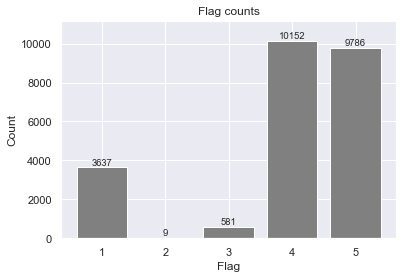

In [10]:
flag_dict = Counter(candidates_comp_stats_noSims['flag'])
flags = [entry[0] for entry in flag_dict.items()]
heights = [entry[1] for entry in flag_dict.items()]

#lable_heights = [h+]

plt.bar(flags, heights, color = 'grey')
plt.title('Flag counts')

plt.ylim(0, max(heights)+0.1*max(heights))

for x, y in zip(flags, heights):
    plt.text(x, y+10, y,
            ha='center', va='bottom', size = 9.5)

plt.xlabel('Flag')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_flag_count_rt0.085.pdf',\
            bbox_inches='tight')

## 5. Merge rows by summing intensities

In [12]:
# loop through candidate list and merge flags 3-4/5

# Clusters to be merged

merge_clusters = candidates_comp_stats_noSims.loc[\
                    candidates_comp_stats_noSims['flag'].isin([3,4]),:]

merge_clusters_3to5 = candidates_comp_stats_noSims.loc[\
                    candidates_comp_stats_noSims['flag'].isin([3,4,5]),:]


In [10]:
# Split up cluster list by strain

strain_idx_list = list(set(merge_clusters['strain_idx']))

merge_cluster_per_strain = []

for strain in strain_idx_list:
    strain_clusters = merge_clusters.loc[merge_clusters['strain_idx'] == strain]
    merge_cluster_per_strain.append(strain_clusters)

In [13]:
# Split up cluster list by strain

strain_idx_list_3to5 = list(set(merge_clusters_3to5['strain_idx']))

merge_cluster_per_strain_3to5 = []

for strain in strain_idx_list_3to5:
    strain_clusters = merge_clusters_3to5.loc[merge_clusters_3to5['strain_idx'] == strain]
    merge_cluster_per_strain_3to5.append(strain_clusters)

Run merging

In [11]:
# run merging (load results below)
untar_fix_merge_perS = []

for strain in strain_idx_list:
    
    print(strain+1, 'of', len(strain_idx_list))
    
    strain_MS_table = per_strain_incl_clusID_min3[strain].copy()
    strain_merge_clusters = merge_cluster_per_strain[strain]
    
    # perform strain check
    MS_strain = strain_MS_table.columns[0].split('-')[3]
    merge_cluster_strain = strain_merge_clusters['strain'][0]
    
    if MS_strain != merge_cluster_strain:
        print(MS_strain, 'mass spec data does not match', merge_cluster_strain,\
              'merge clusters')
        break 
    
    # merge rows in MS data tables
    for idx in strain_merge_clusters.index:
        clus_id = strain_merge_clusters.loc[idx, 'cluster_id']
        
        clus_rows = strain_MS_table.loc[strain_MS_table['cluster_id'] == clus_id, :]
        
        # take row with higher number of values as reference
        n_row_vals = clus_rows.count(axis=1)
        ref_row = clus_rows.loc[[n_row_vals.idxmax()],:]
        
        # set intesity values to sum of columns
        sum_vals = clus_rows.iloc[:,:-4].sum()
        sum_vals = list(sum_vals.replace(to_replace = 0, value = np.float('nan')))
        ref_row.iloc[:,:-4] = sum_vals
        
        # add merged column to original data frame
        strain_MS_table.loc[ref_row.index, :] = ref_row
        
        # remove non ref rows
        rm_idx_list = [idx for idx in clus_rows.index if idx != ref_row.index]
        strain_MS_table = strain_MS_table.drop(index = rm_idx_list)
    
    # save table
    s_name = strain_MS_table.columns[0].split('-')[3]
    strain_MS_table.to_csv('intermed_results/03_fix_missMerge/data/untargeted_tables/'+\
                     str(strain+1).zfill(2)+'_fix_merge_flag3_4_'+s_name+'.txt', sep = ';')
    # add to list
    untar_fix_merge_perS.append(strain_MS_table)

1 of 76
2 of 76
3 of 76
4 of 76
5 of 76
6 of 76
7 of 76
8 of 76
9 of 76
10 of 76
11 of 76
12 of 76
13 of 76
14 of 76
15 of 76
16 of 76
17 of 76
18 of 76
19 of 76
20 of 76
21 of 76
22 of 76
23 of 76
24 of 76
25 of 76
26 of 76
27 of 76
28 of 76
29 of 76
30 of 76
31 of 76
32 of 76
33 of 76
34 of 76
35 of 76
36 of 76
37 of 76
38 of 76
39 of 76
40 of 76
41 of 76
42 of 76
43 of 76
44 of 76
45 of 76
46 of 76
47 of 76
48 of 76
49 of 76
50 of 76
51 of 76
52 of 76
53 of 76
54 of 76
55 of 76
56 of 76
57 of 76
58 of 76
59 of 76
60 of 76
61 of 76
62 of 76
63 of 76
64 of 76
65 of 76
66 of 76
67 of 76
68 of 76
69 of 76
70 of 76
71 of 76
72 of 76
73 of 76
74 of 76
75 of 76
76 of 76


In [15]:
# run merging (load results below, test if merging of flag 5 candidates is suitable)
untar_fix_merge_perS_3to5 = []

for strain in strain_idx_list_3to5:
    
    print(strain+1, 'of', len(strain_idx_list_3to5))
    
    strain_MS_table = per_strain_incl_clusID_min3[strain].copy()
    strain_merge_clusters = merge_cluster_per_strain_3to5[strain]
    
    # perform strain check
    MS_strain = strain_MS_table.columns[0].split('-')[3]
    merge_cluster_strain = strain_merge_clusters['strain'][0]
    
    if MS_strain != merge_cluster_strain:
        print(MS_strain, 'mass spec data does not match', merge_cluster_strain,\
              'merge clusters')
        break 
    
    # merge rows in MS data tables
    for idx in strain_merge_clusters.index:
        clus_id = strain_merge_clusters.loc[idx, 'cluster_id']
        
        clus_rows = strain_MS_table.loc[strain_MS_table['cluster_id'] == clus_id, :]
        
        # take row with higher number of values as reference
        n_row_vals = clus_rows.count(axis=1)
        ref_row = clus_rows.loc[[n_row_vals.idxmax()],:]
        
        # set intesity values to sum of columns
        sum_vals = clus_rows.iloc[:,:-4].sum()
        sum_vals = list(sum_vals.replace(to_replace = 0, value = np.float('nan')))
        ref_row.iloc[:,:-4] = sum_vals
        
        # add merged column to original data frame
        strain_MS_table.loc[ref_row.index, :] = ref_row
        
        # remove non ref rows
        rm_idx_list = [idx for idx in clus_rows.index if idx != ref_row.index]
        strain_MS_table = strain_MS_table.drop(index = rm_idx_list)
    
    # save table
    s_name = strain_MS_table.columns[0].split('-')[3]
    strain_MS_table.to_csv('intermed_results/03_fix_missMerge/data/untargeted_tables/'+\
                     str(strain+1).zfill(2)+'_fix_merge_flag3_5_'+s_name+'.txt', sep = ';')
    # add to list
    untar_fix_merge_perS_3to5.append(strain_MS_table)

1 of 76
2 of 76
3 of 76
4 of 76
5 of 76
6 of 76
7 of 76
8 of 76
9 of 76
10 of 76
11 of 76
12 of 76
13 of 76
14 of 76
15 of 76
16 of 76
17 of 76
18 of 76
19 of 76
20 of 76
21 of 76
22 of 76
23 of 76
24 of 76
25 of 76
26 of 76
27 of 76
28 of 76
29 of 76
30 of 76
31 of 76
32 of 76
33 of 76
34 of 76
35 of 76
36 of 76
37 of 76
38 of 76
39 of 76
40 of 76
41 of 76
42 of 76
43 of 76
44 of 76
45 of 76
46 of 76
47 of 76
48 of 76
49 of 76
50 of 76
51 of 76
52 of 76
53 of 76
54 of 76
55 of 76
56 of 76
57 of 76
58 of 76
59 of 76
60 of 76
61 of 76
62 of 76
63 of 76
64 of 76
65 of 76
66 of 76
67 of 76
68 of 76
69 of 76
70 of 76
71 of 76
72 of 76
73 of 76
74 of 76
75 of 76
76 of 76


In [20]:
# load tables

fix_merge_table_paths = glob.glob(\
    'intermed_results/03_fix_missMerge/data/untargeted_tables/*_fix_merge_flag3_4_*')
untar_fix_merge_perS = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in fix_merge_table_paths]

del(fix_merge_table_paths)

In [ ]:
# load tables

fix_merge_table_paths = glob.glob(\
    'intermed_results/03_fix_missMerge/data/untargeted_tables/*_fix_merge_flag3_5_*')
untar_fix_merge_perS_3to5 = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in fix_merge_table_paths]

del(fix_merge_table_paths)

## 6. Assess quality of merging

In [16]:
# IS masses

IS_list_full_name = ['IS_SPARTEINE', 'IS_EMETINE','IS_CAFFEINE',
                     'IS_YOHIMBINE', 'IS_SULFAMETHOXAZOLE', 'IS_EYTHROMYCINE',
                     'IS_MIFEPRISTONE', 'IS_IPRIFLAVONE'] # names in targeted data tables

IS_mass_refs =  [
        234.20960, #sparteine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:28827
        480.29881, #emetine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:4781
        194.08038, #caffeine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:27732
        354.19434, #yohimbine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:10093
        253.05211, #sulfamethoxazole: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:9332
        733.46124, #erythromycin A (questionalble): https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:42355
        429.26678, #mifepristone: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:50692
        280.10994  #ipriflavone: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:31719
        ]

IS_dict = dict(zip(IS_list_full_name, IS_mass_refs))

#IS_total_names = ['sparteine', 'emetine', 'caffeine', 'yohimbine','sulfamethoxazole', \
#                  'erythromycin A', 'mifepristone', 'ipriflavone']


In [17]:
# drug masses

drug_dict = dict(zip(screen_info.index, screen_info['TargetedMZ']))

In [76]:
# Find rows in original and merged untargeted data tables

# IS rows original

IS_rows_orig = []
merge_records = []

for i, table in enumerate(per_strain_incl_clusID_min3):
    
    for entry in IS_dict.items():
        
        IS_rows = table.loc[table['Mass'] >= (entry[1]-0.001) ,:]
        IS_rows = IS_rows.loc[IS_rows['Mass'] <= (entry[1]+0.001), :]
        
        merge_clus_strain = merge_clusters.loc[merge_clusters['strain_idx']==i,:]
        
        clus_of_interest = list(set(IS_rows['cluster_id']))
        
        extract_list = [clus_id for clus_id in clus_of_interest if clus_id in \
                           list(merge_clus_strain['cluster_id'])]
        #merge_bool = [j in list(merge_clus_strain['cluster_id']) for j in IS_rows['cluster_id']]
        
        IS_rows = table[table['cluster_id'].isin(extract_list)]
        
        if IS_rows.shape[0]>0:
            merge_records.append([i, IS_rows.index, IS_rows.shape[0], IS_rows['cluster_id'],\
                                  list(merge_clus_strain[merge_clus_strain['cluster_id'].isin(\
                                    extract_list)]['flag']), entry[0]])
        
            IS_rows_orig.append(IS_rows)
    
    

In [98]:
# IS rows original _3to5

IS_rows_orig_3to5 = []
merge_records_3to5 = []

for i, table in enumerate(per_strain_incl_clusID_min3):
    
    for entry in IS_dict.items():
        
        IS_rows = table.loc[table['Mass'] >= (entry[1]-0.001) ,:]
        IS_rows = IS_rows.loc[IS_rows['Mass'] <= (entry[1]+0.001), :]
        
        merge_clus_strain = merge_clusters_3to5.loc[merge_clusters_3to5['strain_idx']==i,:]
        clus_of_interest = list(set(IS_rows['cluster_id']))
        
        extract_list = [clus_id for clus_id in clus_of_interest if clus_id in \
                           list(merge_clus_strain['cluster_id'])]
        #merge_bool = [j in list(merge_clus_strain['cluster_id']) for j in IS_rows['cluster_id']]
        
        IS_rows = table[table['cluster_id'].isin(extract_list)]
        
        if IS_rows.shape[0]>0:
            merge_records_3to5.append([i, IS_rows.index, IS_rows.shape[0], IS_rows['cluster_id'],\
                                  list(merge_clus_strain[merge_clus_strain['cluster_id'].isin(\
                                    extract_list)]['flag']), entry[0]])
        
            IS_rows_orig_3to5.append(IS_rows)
    
    

In [104]:
merge_records_3to5
#merge_records

test_record = 1
check_row = per_strain_incl_clusID_min3[merge_records_3to5[test_record][0]].loc[merge_records_3to5[test_record][1],:]
#check_row = per_strain_incl_clusID_min3[merge_records[test_record][0]].loc[merge_records[test_record][1],:]
check_row

MZ002H-Pool01-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool01-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool02-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool02-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool03-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool03-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool04-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool04-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                            639862.0   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool05-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool05-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool06-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool06-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool07-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool07-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                            699843.0   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool08-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                                 NaN   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool08-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.0426667                            759810.0   
480.299@2.1243334                                 NaN   

                   MZ002H-Pool09-P003A2-S026-T00(raw)  \
Compound                                                
480.299@2.0426667                            226119.0   
480.299@2.1243334                             40823.0   

                   MZ002H-Pool09-P003A2-S026-T12(raw)  \
Compound                                                
480.299@2.04

In [21]:
# IS rows merged

IS_rows_fixed = []

for entry in merge_records:
    
    strain_idx = entry[0]
    clus_id = entry[3][0]
    
    strain_table = untar_fix_merge_perS[strain_idx]
    fixed_row = strain_table.loc[strain_table['cluster_id'] == clus_id,:]
    
    IS_rows_fixed.append(fixed_row)

In [105]:
# IS rows merged_3to5

IS_rows_fixed_3to5 = []

for entry in merge_records_3to5:
    
    strain_idx = entry[0]
    clus_id = entry[3][0]
    
    strain_table = untar_fix_merge_perS_3to5[strain_idx]
    fixed_row = strain_table.loc[strain_table['cluster_id'] == clus_id,:]
    
    IS_rows_fixed_3to5.append(fixed_row)

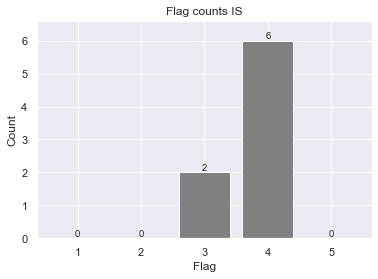

In [16]:
# extract flags and plot bar plot

IS_flag_list = [e[4][0] for e in merge_records]

flag_dict = Counter(IS_flag_list)
flags = [1,2,3,4,5]
heights = []
for f in flags:
    if f in flag_dict.keys():
        heights.append(flag_dict[f])
    else:
        heights.append(0)

#lable_heights = [h+]

plt.bar(flags, heights, color = 'grey')
plt.title('Flag counts IS')

plt.ylim(0, max(heights)+0.1*max(heights))

for x, y in zip(flags, heights):
    plt.text(x, y, y,
            ha='center', va='bottom', size = 9.5)

plt.xlabel('Flag')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_flag_count_IS_rt0.085.pdf',\
            bbox_inches='tight')

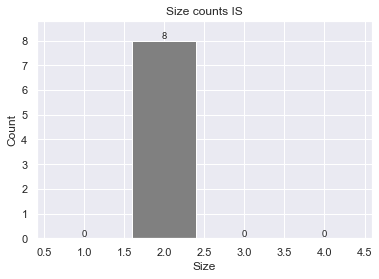

In [17]:
# extract sizes and plot bar plot

IS_flag_list = [e[2] for e in merge_records]

flag_dict = Counter(IS_flag_list)
flags = [1,2,3,4]
heights = []
for f in flags:
    if f in flag_dict.keys():
        heights.append(flag_dict[f])
    else:
        heights.append(0)

#lable_heights = [h+]

plt.bar(flags, heights, color = 'grey')
plt.title('Size counts IS')

plt.ylim(0, max(heights)+0.1*max(heights))

for x, y in zip(flags, heights):
    plt.text(x, y, y,
            ha='center', va='bottom', size = 9.5)

plt.xlabel('Size')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_size_count_IS_rt0.085.pdf',\
            bbox_inches='tight')

Repeat with drugs

In [106]:
# Find rows in original and merged untargeted data tables

# drug rows original

drug_rows_orig = []
drug_merge_records = []

for i, table in enumerate(per_strain_incl_clusID_min3):
    
    
    for entry in drug_dict.items():
        
        IS_rows = table.loc[table['Mass'] >= (entry[1]-0.001) ,:]
        IS_rows = IS_rows.loc[IS_rows['Mass'] <= (entry[1]+0.001), :]
        
        merge_clus_strain = merge_clusters.loc[merge_clusters['strain_idx']==i,:]
        clus_of_interest = list(set(IS_rows['cluster_id']))
        
        extract_list = [clus_id for clus_id in clus_of_interest if clus_id in \
                           list(merge_clus_strain['cluster_id'])]
        #merge_bool = [j in list(merge_clus_strain['cluster_id']) for j in IS_rows['cluster_id']]
        
        IS_rows = table[table['cluster_id'].isin(extract_list)]
        
        if IS_rows.shape[0]>0:
            drug_merge_records.append([i, IS_rows.index, IS_rows.shape[0], IS_rows['cluster_id'],\
                                  list(merge_clus_strain[merge_clus_strain['cluster_id'].isin(\
                                            extract_list)]['flag']), entry[0]])
        
            drug_rows_orig.append(IS_rows)

In [107]:
# drug rows original_3to5

drug_rows_orig_3to5 = []
drug_merge_records_3to5 = []

for i, table in enumerate(per_strain_incl_clusID_min3):
    
    
    for entry in drug_dict.items():
        
        IS_rows = table.loc[table['Mass'] >= (entry[1]-0.001) ,:]
        IS_rows = IS_rows.loc[IS_rows['Mass'] <= (entry[1]+0.001), :]
        
        merge_clus_strain = merge_clusters_3to5.loc[merge_clusters_3to5['strain_idx']==i,:]
        
        clus_of_interest = list(set(IS_rows['cluster_id']))
        
        extract_list = [clus_id for clus_id in clus_of_interest if clus_id in \
                           list(merge_clus_strain['cluster_id'])]
        #merge_bool = [j in list(merge_clus_strain['cluster_id']) for j in IS_rows['cluster_id']]
        
        IS_rows = table[table['cluster_id'].isin(extract_list)]
        
        if IS_rows.shape[0]>0:
            drug_merge_records_3to5.append([i, IS_rows.index, IS_rows.shape[0], IS_rows['cluster_id'],\
                                  list(merge_clus_strain[merge_clus_strain['cluster_id'].isin(\
                                            extract_list)]['flag']), entry[0]])
        
            drug_rows_orig_3to5.append(IS_rows)

In [123]:
print(len(drug_merge_records_3to5))
print(len(drug_merge_records))

test_record = 7

display(drug_merge_records_3to5[test_record])

check_row = per_strain_incl_clusID_min3[drug_merge_records_3to5[test_record][0]].loc[drug_merge_records_3to5[test_record][1],:]
#check_row = per_strain_incl_clusID_min3[drug_merge_records[test_record][0]].loc[drug_merge_records[test_record][1],:]
check_row

595
385


[0,
 Index(['266.1158@4.6063695', '266.1159@4.647875'], dtype='object', name='Compound'),
 2,
 Compound
 266.1158@4.6063695    002389_3_0
 266.1159@4.647875     002389_3_0
 Name: cluster_id, dtype: object,
 [5],
 'NEVIRAPINE']

MZ002H-Pool01-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            405844.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool01-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            329441.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool02-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            383465.0   
266.1159@4.647875                             295419.0   

                    MZ002H-Pool02-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            533976.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool03-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            711243.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool03-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            266204.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool04-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            910458.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool04-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            746723.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool05-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            449840.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool05-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            341818.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool06-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            881759.0   
266.1159@4.647875                             718052.0   

                    MZ002H-Pool06-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                                 NaN   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool07-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            728447.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool07-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            743938.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool08-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                           1205795.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool08-P001B1-S005-T12(raw)  \
Compound                                                 
266.1158@4.6063695                            984553.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool09-P001B1-S005-T00(raw)  \
Compound                                                 
266.1158@4.6063695                            703519.0   
266.1159@4.647875                                  NaN   

                    MZ002H-Pool09-P001B1-S005-T12(raw)  \
C

In [124]:
# drug rows merged

drug_rows_fixed = []

for entry in drug_merge_records:
    
    strain_idx = entry[0]
    clus_ids = list(set(entry[3]))
    
    strain_table = untar_fix_merge_perS[strain_idx]
    fixed_row = strain_table.loc[strain_table['cluster_id'].isin(clus_ids),:]
    
    drug_rows_fixed.append(fixed_row)

In [125]:
# drug rows merged

drug_rows_fixed_3to5 = []

for entry in drug_merge_records_3to5:
    
    strain_idx = entry[0]
    clus_ids = list(set(entry[3]))
    
    strain_table = untar_fix_merge_perS_3to5[strain_idx]
    fixed_row = strain_table.loc[strain_table['cluster_id'].isin(clus_ids),:]
    
    drug_rows_fixed_3to5.append(fixed_row)

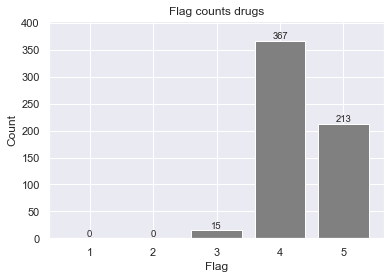

In [126]:
# extract flags and plot bar plot

drug_flag_list = [e[4][0] for e in drug_merge_records]

flag_dict = Counter(drug_flag_list)
flags = [1,2,3,4,5]
heights = []
for f in flags:
    if f in flag_dict.keys():
        heights.append(flag_dict[f])
    else:
        heights.append(0)

#lable_heights = [h+]

plt.bar(flags, heights, color = 'grey')
plt.title('Flag counts drugs')

plt.ylim(0, max(heights)+0.1*max(heights))

for x, y in zip(flags, heights):
    plt.text(x, y, y,
            ha='center', va='bottom', size = 9.5)

plt.xlabel('Flag')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_flag_count_drugs_rt0.085.pdf',\
            bbox_inches='tight')

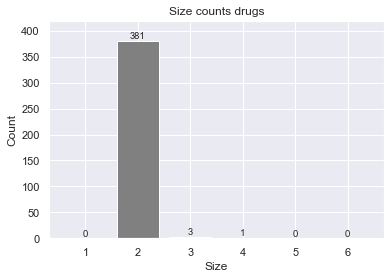

In [21]:
# extract sizes and plot bar plot

drug_flag_list = [e[2] for e in drug_merge_records]

flag_dict = Counter(drug_flag_list)
flags = [1,2,3,4,5,6]
heights = []
for f in flags:
    if f in flag_dict.keys():
        heights.append(flag_dict[f])
    else:
        heights.append(0)

#lable_heights = [h+]

plt.bar(flags, heights, color = 'grey')
plt.title('Size counts drugs')

plt.ylim(0, max(heights)+0.1*max(heights))

for x, y in zip(flags, heights):
    plt.text(x, y, y,
            ha='center', va='bottom', size = 9.5)

plt.xlabel('Size')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_size_count_drugs_rt0.085.pdf',\
            bbox_inches='tight')

In [130]:
# check whether any record has multiple cluster ids:

clus_num_recods = []

for entry in drug_merge_records:
    
    clus_ids = entry[3]
    c_num = len(set(clus_ids))
    clus_num_recods.append(c_num)

Counter(clus_num_recods)

Counter({1: 384, 2: 1})

In [129]:
# check whether any record has multiple cluster ids:

clus_num_recods_3to5 = []

for entry in drug_merge_records_3to5:
    
    clus_ids = entry[3]
    c_num = len(set(clus_ids))
    clus_num_recods_3to5.append(c_num)

Counter(clus_num_recods_3to5)

Counter({1: 586, 2: 9})

In [29]:
drug_merge_records[clus_num_recods.index(2)]

[29,
 Index(['266.1158@4.4796004', '266.1158@4.622356', '266.1159@4.5410004',
        '266.1159@4.6805'],
       dtype='object', name='Compound'),
 4,
 Compound
 266.1158@4.4796004    002830_3_1
 266.1158@4.622356     002830_3_0
 266.1159@4.5410004    002830_3_1
 266.1159@4.6805       002830_3_0
 Name: cluster_id, dtype: object,
 [4, 4],
 'NEVIRAPINE']

In [33]:
strain_table = per_strain_incl_clusID_min3[29]

clus_row = strain_table.loc[strain_table['cluster_id'].isin(['002830_3_1', '002830_3_0'])]

clus_row

MZ002H-Pool01-P004A1-S037-T00(raw)  \
Compound                                                 
266.1158@4.4796004                                 NaN   
266.1158@4.622356                                  NaN   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool01-P004A1-S037-T12(raw)  \
Compound                                                 
266.1158@4.4796004                            100472.0   
266.1158@4.622356                             112305.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool02-P004A1-S037-T00(raw)  \
Compound                                                 
266.1158@4.4796004                            104119.0   
266.1158@4.622356                            1134462.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool02-P004A1-S037-T12(raw)  \
Compound                                                 
266.1158@4.4796004                            108989.0   
266.1158@4.622356                            1166566.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool03-P004A1-S037-T00(raw)  \
Compound                                                 
266.1158@4.4796004                            383836.0   
266.1158@4.622356                             860134.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool03-P004A1-S037-T12(raw)  \
Compound                                                 
266.1158@4.4796004                                 NaN   
266.1158@4.622356                             672345.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool04-P004A1-S037-T00(raw)  \
Compound                                                 
266.1158@4.4796004                                 NaN   
266.1158@4.622356                            1417603.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool04-P004A1-S037-T12(raw)  \
Compound                                                 
266.1158@4.4796004                            635577.0   
266.1158@4.622356                            1316604.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool05-P004A1-S037-T00(raw)  \
Compound                                                 
266.1158@4.4796004                                 NaN   
266.1158@4.622356                            1526957.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool05-P004A1-S037-T12(raw)  \
Compound                                                 
266.1158@4.4796004                                 NaN   
266.1158@4.622356                            1447514.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool06-P004A1-S037-T00(raw)  \
Compound                                                 
266.1158@4.4796004                                 NaN   
266.1158@4.622356                            2277629.0   
266.1159@4.5410004                                 NaN   
266.1159@4.6805                                    NaN   

                    MZ002H-Pool06-P004A1-S037-T12(raw)  \
Compound                                                 
266.1158@4.4796004                            594365.0   
266.115

#### Quality metric: Value count per row

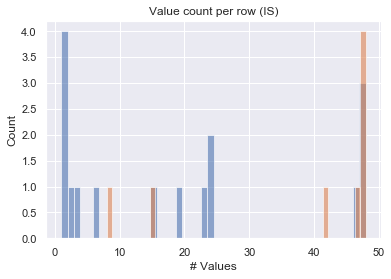

In [131]:
orig_val_count_IS = []

for df in IS_rows_orig:
    
    counts = list(df.count(axis=1)-4) # minus 4 nc of info columns at the end
    orig_val_count_IS.extend(counts)


fixed_val_count_IS = []

for df in IS_rows_fixed:
    
    counts = list(df.count(axis=1)-4) # minus 4 nc of info columns at the end
    fixed_val_count_IS.extend(counts)

#fixed_val_count_IS

#fixed_val_count_IS

plt.hist(orig_val_count_IS, alpha = 0.6, bins = 48)

plt.hist(fixed_val_count_IS, alpha = 0.6, bins = 48)

plt.title('Value count per row (IS)')
plt.xlabel('# Values')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_IS_count_per_row_rt0.085.pdf',\
            bbox_inches='tight')

41
36


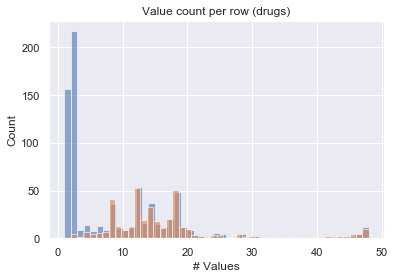

In [132]:
orig_val_count_drugs = []
orig_8_counts = []

for df in drug_rows_orig:
    
    counts = list(df.count(axis=1)-4) # minus 4 nc of info columns at the end
    if 8 in counts:
        orig_8_counts.append(df)
    orig_val_count_drugs.extend(counts)


fixed_val_count_drugs = []
fixed_8_counts = []

for df in drug_rows_fixed:
    
    counts = list(df.count(axis=1)-4) # minus 4 nc of info columns at the end
    if 8 in counts:
        fixed_8_counts.append(df)
    fixed_val_count_drugs.extend(counts)

print(Counter(fixed_val_count_drugs)[8])
print(Counter(orig_val_count_drugs)[8])

#fixed_val_count_IS

plt.hist(orig_val_count_drugs, alpha = 0.6, bins = 47)#, color='blue')

plt.hist(fixed_val_count_drugs, alpha = 0.6, bins = 47)#,color='red')

plt.title('Value count per row (drugs)')
plt.xlabel('# Values')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_drugs_count_per_row_rt0.085.pdf',\
            bbox_inches='tight')


105
103


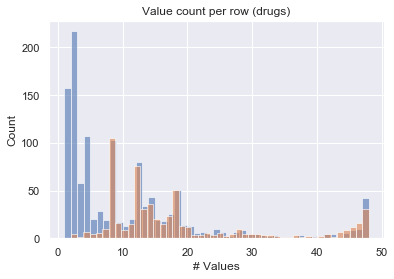

In [133]:
orig_val_count_drugs_3to5 = []
orig_8_counts_3to5 = []

for df in drug_rows_orig_3to5:
    
    counts = list(df.count(axis=1)-4) # minus 4 nc of info columns at the end
    if 8 in counts:
        orig_8_counts_3to5.append(df)
    orig_val_count_drugs_3to5.extend(counts)


fixed_val_count_drugs_3to5 = []
fixed_8_counts_3to5 = []

for df in drug_rows_fixed_3to5:
    
    counts = list(df.count(axis=1)-4) # minus 4 nc of info columns at the end
    if 8 in counts:
        fixed_8_counts_3to5.append(df)
    fixed_val_count_drugs_3to5.extend(counts)


print(Counter(orig_val_count_drugs_3to5)[8])
print(Counter(fixed_val_count_drugs_3to5)[8])

#fixed_val_count_IS

plt.hist(orig_val_count_drugs_3to5, alpha = 0.6, bins = 47)#, color='blue')

plt.hist(fixed_val_count_drugs_3to5, alpha = 0.6, bins = 47)#,color='red')

plt.title('Value count per row (drugs)')
plt.xlabel('# Values')
plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_drugs_count_per_row_rt0.085_3to5.pdf',\
            bbox_inches='tight')


In [134]:
strain_idx_dict = dict(zip(candidates_comp_stats_noSims['strain'],\
                           candidates_comp_stats_noSims['strain_idx'] ))

In [38]:
# get all clus ids and strains present in orig and fixed 8 count

orig_clus_ids = []

for df in orig_8_counts:
    
    strain = df.columns[0].split('-')[3]
    strain_idx = strain_idx_dict[strain]
    clus_ids = list(df['cluster_id'])
    clus_ids_plus_s = [str(strain_idx)+':'+s_str for s_str in clus_ids]
    orig_clus_ids.extend(clus_ids_plus_s)
    
fixed_clus_ids = []

for df in fixed_8_counts:
    
    strain = df.columns[0].split('-')[3]
    strain_idx = strain_idx_dict[strain]
    clus_ids = list(df['cluster_id'])
    clus_ids_plus_s = [str(strain_idx)+':'+s_str for s_str in clus_ids]
    fixed_clus_ids.extend(clus_ids_plus_s)

all_clus_ids = orig_clus_ids + fixed_clus_ids
all_clus_ids_unique = list(set(all_clus_ids))

In [135]:
# get all clus ids and strains present in orig and fixed 8 count

orig_clus_ids_3to5 = []

for df in orig_8_counts_3to5:
    
    strain = df.columns[0].split('-')[3]
    strain_idx = strain_idx_dict[strain]
    clus_ids = list(df['cluster_id'])
    clus_ids_plus_s = [str(strain_idx)+':'+s_str for s_str in clus_ids]
    orig_clus_ids_3to5.extend(clus_ids_plus_s)
    
fixed_clus_ids_3to5 = []

for df in fixed_8_counts_3to5:
    
    strain = df.columns[0].split('-')[3]
    strain_idx = strain_idx_dict[strain]
    clus_ids = list(df['cluster_id'])
    clus_ids_plus_s = [str(strain_idx)+':'+s_str for s_str in clus_ids]
    fixed_clus_ids_3to5.extend(clus_ids_plus_s)

all_clus_ids_3to5 = orig_clus_ids_3to5 + fixed_clus_ids_3to5
all_clus_ids_unique_3to5 = list(set(all_clus_ids_3to5))

In [39]:
# get test records

record_to_test = []

for record in drug_merge_records:
    clus_ids = list(set(record[3]))
    test_idents = [str(record[0])+':'+clus for clus in clus_ids]
    
    if any([c_id in all_clus_ids_unique for c_id in test_idents]):
        record_to_test.append(record)

In [136]:
# get test records

record_to_test_3to5 = []

for record in drug_merge_records_3to5:
    clus_ids = list(set(record[3]))
    test_idents = [str(record[0])+':'+clus for clus in clus_ids]
    
    if any([c_id in all_clus_ids_unique_3to5 for c_id in test_idents]):
        record_to_test_3to5.append(record)

In [137]:
len(record_to_test)

42

In [138]:
len(record_to_test_3to5)

115

In [152]:
untar_row

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 3790156.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2211650.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 2409355.0,
 3281254.0,
 nan,
 nan]

In [165]:
# match with targeted data  (get correlation and value count, includes plotting)

merge_cand_cors = []
cor_info = []

for k, record in enumerate(record_to_test):
    
    orig_table = per_strain_incl_clusID_min3[record[0]]
    fixed_table = untar_fix_merge_perS[record[0]]

    clus_id = list(set(record[3]))[0]

    orig_rows = orig_table.loc[orig_table['cluster_id']==clus_id, :]
    fixed_row = fixed_table.loc[fixed_table['cluster_id']==clus_id, :]

    #display(orig_rows)
    #display(fixed_row)

    tar_table = targeted_perS_list[record[0]]

    drug_name = record[5]
    drug_name = [name for name in tar_table.index if drug_name in name][0]
    
    if drug_name in tar_table.index:
        
        tar_row = tar_table.loc[[drug_name], :]

        #display(tar_row)
        orig_1 = list(orig_rows.iloc[0,:-10])
        orig_2 = list(orig_rows.iloc[1,:-10])
        fixed_1 = list(fixed_row.iloc[0,:-10])

        tar_1 = list(tar_row.iloc[0,:])

        cor_vals = []
        
        # Plotting        
        fig, axs = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (18,5))
        title_list = ['Original row 1', 'Original row 2', 'Fixed row']
        
        for i, row in enumerate([orig_1, orig_2, fixed_1]):

            untar_row = row
            tar_row = tar_1
            
            #untar_val_count = len([num for num in untar_row if not(np.isnan(num))])
            #tar_row_count = len([num for num in tar_row if not(np.isnan(num))])
            
            complete_entries = [[b_1, b_2] for b_1, b_2 in zip(untar_row, tar_row) if not(np.isnan(b_1) or np.isnan(b_2))]
            
            #val_counter.append([untar_val_count,tar_row_count, len(complete_entries)])

            if len(complete_entries) >= 4:
                vec_untar = [el[0] for el in complete_entries]
                vec_tar = [el[1] for el in complete_entries]
                cor_coef = np.corrcoef(vec_untar, vec_tar)[0,1]
                cor_vals.append(cor_coef)
                
                axs[i].scatter(untar_row, tar_row)
                axs[i].set_xlabel('Untargeted data')
                axs[i].set_ylabel('Targeted data')
                axs[i].set_title(title_list[i])
                
            else:
                vec_untar = [el[0] for el in complete_entries]
                vec_tar = [el[1] for el in complete_entries]
                cor_vals.append(0)
                
                axs[i].scatter(untar_row, tar_row)
                axs[i].set_xlabel('Untargeted data')
                axs[i].set_ylabel('Targeted data')
                axs[i].set_title(title_list[i])
            
        cor_vals = [max(cor_vals[0], cor_vals[1]) ,cor_vals[2]]
        
        if not(0 in cor_vals):
            merge_cand_cors.append(cor_vals)

            cor_info.append(record)
            
            plt.savefig('intermed_results/03_fix_missMerge/untar_tar_comp_rt0.085/'+\
                today+'_untar_tar_comp'+str(k)+'.pdf',\
                bbox_inches='tight')
            
            plt.close('all')
        
        else:
            plt.close('all')
        

        
    else:
        print(drug_name, 'not in targeted data')
        next

In [167]:
# match with targeted data  (get correlation and value count, includes plotting)

merge_cand_cors_3to5 = []
cor_info_3to5 = []
#val_counter_3to5 = []

for k, record in enumerate(record_to_test_3to5):
    
    orig_table = per_strain_incl_clusID_min3[record[0]]
    fixed_table = untar_fix_merge_perS_3to5[record[0]]

    clus_id = list(set(record[3]))[0]

    orig_rows = orig_table.loc[orig_table['cluster_id']==clus_id, :]
    fixed_row = fixed_table.loc[fixed_table['cluster_id']==clus_id, :]

    #display(orig_rows)
    #display(fixed_row)

    tar_table = targeted_perS_list[record[0]]

    drug_name = record[5]
    drug_name = [name for name in tar_table.index if drug_name in name][0]
    
    if drug_name in tar_table.index:
        
        tar_row = tar_table.loc[[drug_name], :]

        #display(tar_row)
        orig_1 = list(orig_rows.iloc[0,:-10])
        orig_2 = list(orig_rows.iloc[1,:-10])
        fixed_1 = list(fixed_row.iloc[0,:-10])

        tar_1 = list(tar_row.iloc[0,:])

        cor_vals = []
        
        # Plotting        
        fig, axs = plt.subplots(1, 3, sharey = True, sharex = True, figsize = (18,5))
        title_list = ['Original row 1', 'Original row 2', 'Fixed row']
        
        for i, row in enumerate([orig_1, orig_2, fixed_1]):

            untar_row = row
            tar_row = tar_1
            
            #untar_val_count = untar_row.count()
            #tar_row_count = tar_row.count()

            complete_entries = [[b_1, b_2] for b_1, b_2 in zip(untar_row, tar_row) if not(np.isnan(b_1) or np.isnan(b_2))]

            if len(complete_entries) >= 6:
                vec_untar = [el[0] for el in complete_entries]
                vec_tar = [el[1] for el in complete_entries]
                cor_coef = np.corrcoef(vec_untar, vec_tar)[0,1]
                cor_vals.append(cor_coef)
                
                axs[i].scatter(vec_untar, vec_tar)
                axs[i].set_xlabel('Untargeted data')
                axs[i].set_ylabel('Targeted data')
                axs[i].set_title(title_list[i])
                
            else:
                vec_untar = [el[0] for el in complete_entries]
                vec_tar = [el[1] for el in complete_entries]
                cor_vals.append(0)
                
                axs[i].scatter(vec_untar, vec_tar)
                axs[i].set_xlabel('Untargeted data')
                axs[i].set_ylabel('Targeted data')
                axs[i].set_title(title_list[i])
            
        cor_vals = [max(cor_vals[0], cor_vals[1]) ,cor_vals[2]]
        
        if not(0 in cor_vals):
            merge_cand_cors_3to5.append(cor_vals)
                        
            cor_info_3to5.append(record)
            
            plt.savefig('intermed_results/03_fix_missMerge/untar_tar_comp_rt0.085/'+\
                today+'_untar_tar_comp_3to5'+str(k)+'.pdf',\
                bbox_inches='tight')
            
            plt.close('all')
        
        else:
            plt.close('all')
        

        
    else:
        print(drug_name, 'not in targeted data')
        next

In [144]:
len(merge_cand_cors)

26

In [143]:
len(merge_cand_cors_3to5)

81

In [168]:
cor_info_3to5[:1]

[[1,
  Index(['404.2563@5.0606666', '404.2565@4.9975'], dtype='object', name='Compound'),
  2,
  Compound
  404.2563@5.0606666    005494_0_0
  404.2565@4.9975       005494_0_0
  Name: cluster_id, dtype: object,
  [5],
  'LOVASTATIN']]

In [171]:
flag_lables = [el[4][0] for el in cor_info_3to5]

Counter(flag_lables)

Counter({5: 55, 4: 25, 3: 1})

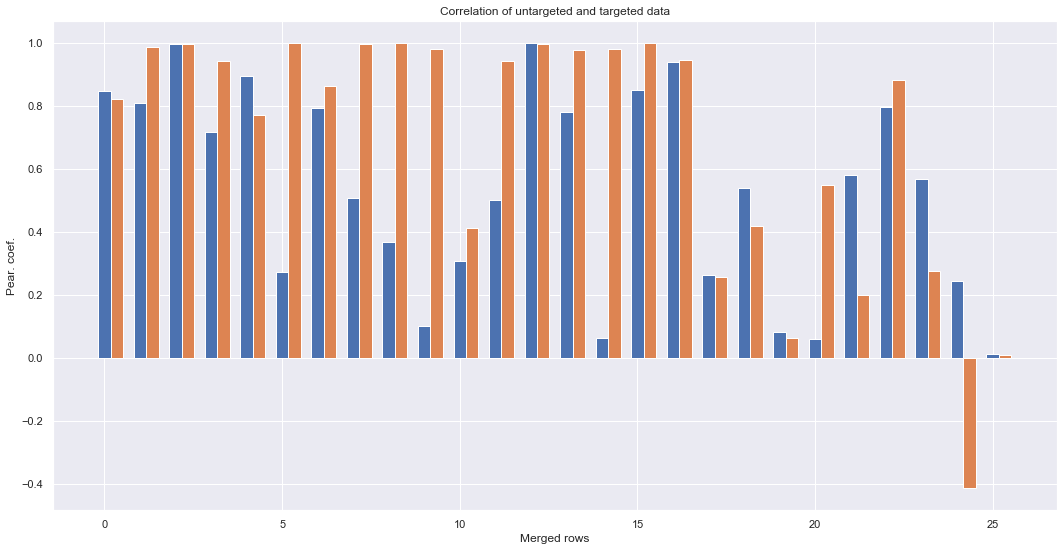

In [66]:
#merge_cand_cors_no0 = [el for el in merge_cand_cors if not(0 in el)]

cors_orig = [el[0] for el in merge_cand_cors]
cors_fixed = [el[1] for el in merge_cand_cors]

x_vec = np.arange(len(cors_orig))
width = 0.35

plt.figure(figsize=(18,9))

plt.bar(x_vec, cors_orig, width)
plt.bar(x_vec+width, cors_fixed, width)

plt.title('Correlation of untargeted and targeted data')
plt.xlabel('Merged rows')
plt.ylabel('Pear. coef.')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_untar_tar_cor_overview_rt0.085.pdf',\
            bbox_inches='tight')

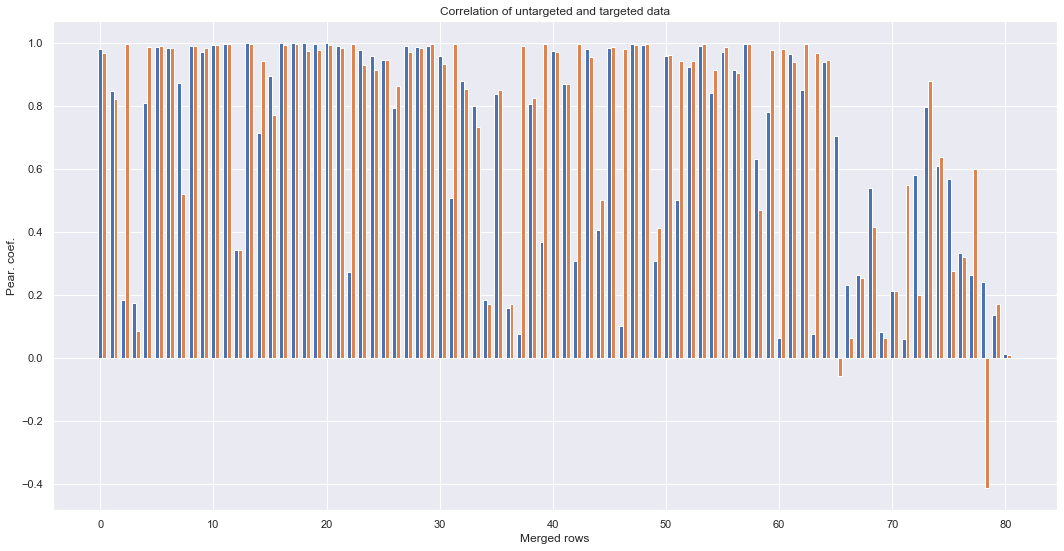

In [145]:
#merge_cand_cors_no0 = [el for el in merge_cand_cors if not(0 in el)]

cors_orig = [el[0] for el in merge_cand_cors_3to5]
cors_fixed = [el[1] for el in merge_cand_cors_3to5]

x_vec = np.arange(len(cors_orig))
width = 0.35

plt.figure(figsize=(18,9))

plt.bar(x_vec, cors_orig, width)
plt.bar(x_vec+width, cors_fixed, width)

plt.title('Correlation of untargeted and targeted data')
plt.xlabel('Merged rows')
plt.ylabel('Pear. coef.')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_untar_tar_cor_overview_rt0.085_3to5.pdf',\
            bbox_inches='tight')

In [147]:
orig_count = 0
fixed_count = 0
no_change_count = 0

for entry in merge_cand_cors:
    if abs(entry[0] - entry[1]) < 0.05:
        no_change_count = no_change_count + 1
    else:
        if (entry[0] - entry[1]) > 0:
            orig_count = orig_count + 1
        else:
            fixed_count = fixed_count + 1

print('Cases with higher cor. for orig. data:', orig_count)
print('Cases with higher cor. for fixed data:', fixed_count)
print('Cases with no change:', no_change_count)

Cases with higher cor. for orig. data: 5
Cases with higher cor. for fixed data: 14
Cases with no change: 7


In [174]:
orig_count_3to5 = 0
fixed_count_3to5 = 0
no_change_count_3to5 = 0

orig_flags_3to5 = []
fixed_flags_3to5 = []
no_change_flags_3to5 = []

for i, entry in enumerate(merge_cand_cors_3to5):
    if abs(entry[0] - entry[1]) < 0.05:
        no_change_count_3to5 = no_change_count_3to5 + 1
        no_change_flags_3to5.append(cor_info_3to5[i])
    else:
        if (entry[0] - entry[1]) > 0:
            orig_count_3to5 = orig_count_3to5 + 1
            orig_flags_3to5.append(cor_info_3to5[i])
        else:
            fixed_count_3to5 = fixed_count_3to5 + 1
            fixed_flags_3to5.append(cor_info_3to5[i])

print('Cases with higher cor. for orig. data:', orig_count_3to5)
print('Cases with higher cor. for fixed data:', fixed_count_3to5)
print('Cases with no change:', no_change_count_3to5)

Cases with higher cor. for orig. data: 11
Cases with higher cor. for fixed data: 21
Cases with no change: 49


In [186]:
#merge_records_3to5
#merge_records
#fixed_flags_3to5
#display(orig_flags_3to5)

test_record = 8
check_row = per_strain_incl_clusID_min3[orig_flags_3to5[test_record][0]].loc[orig_flags_3to5[test_record][1],:]
#check_row = per_strain_incl_clusID_min3[merge_records[test_record][0]].loc[merge_records[test_record][1],:]
check_row

MZ002H-Pool01-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool01-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool02-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool02-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool03-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool03-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool04-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool04-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool05-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                            939754.0   

                    MZ002H-Pool05-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                            983497.0   

                    MZ002H-Pool06-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool06-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool07-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                               1198947.0   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool07-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                           1102375.0   

                    MZ002H-Pool08-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool08-P007C1-S073-T12(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool09-P007C1-S073-T00(raw)  \
Compound                                                 
278.1789@2.513                                     NaN   
278.1791@2.4302857                                 NaN   

                    MZ002H-Pool09-P007C1-S073-T12(raw)  \
C

In [187]:
orig_flags_3to5[8]

[63,
 Index(['278.1789@2.513', '278.1791@2.4302857'], dtype='object', name='Compound'),
 2,
 Compound
 278.1789@2.513        002327_1_0
 278.1791@2.4302857    002327_1_0
 Name: cluster_id, dtype: object,
 [4],
 'TRIPROLIDINE']

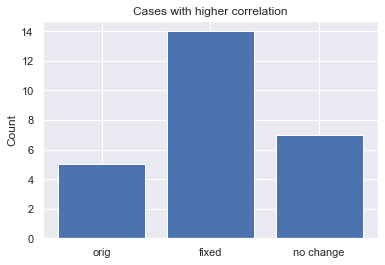

In [68]:
cor_change_count = [orig_count, fixed_count, no_change_count]

plt.bar(['orig', 'fixed', 'no change'], cor_change_count)

plt.title('Cases with higher correlation')

plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_untar_tar_cor_summary_rt0.085.pdf',\
            bbox_inches='tight')

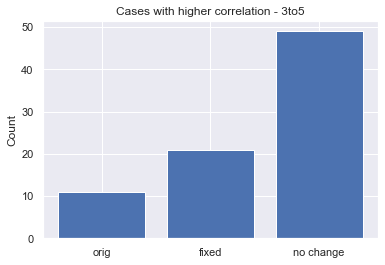

In [150]:
cor_change_count_3to5 = [orig_count_3to5, fixed_count_3to5, no_change_count_3to5]

plt.bar(['orig', 'fixed', 'no change'], cor_change_count_3to5)

plt.title('Cases with higher correlation - 3to5')

plt.ylabel('Count')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_untar_tar_cor_summary_rt0.085_3to5.pdf',\
            bbox_inches='tight')

In [72]:
no_bool = [i for i, entry in enumerate(merge_cand_cors) if abs(entry[0] - entry[1]) < 0.05]
orig_bool = [i for i, entry in enumerate(merge_cand_cors) if (entry[0] - entry[1]) > 0.05]
fixed_bool = [i for i, entry in enumerate(merge_cand_cors) if (entry[0] - entry[1]) < -0.05]

neg_changes = [record_to_test[i] for i in orig_bool]
pos_changes = [record_to_test[i] for i in fixed_bool]
no_changes = [record_to_test[i] for i in no_bool]

#no_changes
#pos_changes
neg_changes
#orig_bool
#fixed_bool

[[5,
  Index(['399.1687@3.2696252', '399.169@3.3375'], dtype='object', name='Compound'),
  2,
  Compound
  399.1687@3.2696252    004974_0_0
  399.169@3.3375        004974_0_0
  Name: cluster_id, dtype: object,
  [4],
  'COLCHICINE'],
 [44,
  Index(['279.1628@2.7537498', '279.1629@2.788'], dtype='object', name='Compound'),
  2,
  Compound
  279.1628@2.7537498    002829_0_0
  279.1629@2.788        002829_0_0
  Name: cluster_id, dtype: object,
  [4],
  'DOXEPIN'],
 [51,
  Index(['291.1992@3.4689999', '291.1992@3.4700003'], dtype='object', name='Compound'),
  2,
  Compound
  291.1992@3.4689999    003169_0_0
  291.1992@3.4700003    003169_0_0
  Name: cluster_id, dtype: object,
  [4],
  'TERBINAFINE'],
 [52,
  Index(['481.1688@3.9457498', '481.1693@3.908'], dtype='object', name='Compound'),
  2,
  Compound
  481.1688@3.9457498    007876_0_0
  481.1693@3.908        007876_0_0
  Name: cluster_id, dtype: object,
  [4],
  'ROSUVASTATIN CALCIUM'],
 [55,
  Index(['404.2568@5.0202', '404.2568@5.070

In [189]:
no_bool_3to5 = [i for i, entry in enumerate(merge_cand_cors_3to5) if abs(entry[0] - entry[1]) < 0.05]
orig_bool_3to5 = [i for i, entry in enumerate(merge_cand_cors_3to5) if (entry[0] - entry[1]) > 0.05]
fixed_bool_3to5 = [i for i, entry in enumerate(merge_cand_cors_3to5) if (entry[0] - entry[1]) < -0.05]

neg_changes_3to5 = [record_to_test_3to5[i] for i in orig_bool_3to5]
pos_changes_3to5 = [record_to_test_3to5[i] for i in fixed_bool_3to5]
no_changes_3to5 = [record_to_test_3to5[i] for i in no_bool_3to5]

#no_changes_3to5
#pos_changes_3to5
#neg_changes_3to5
#orig_bool_3to5
#fixed_bool_3to5

In [70]:
neg_RT_diff = []

for record in neg_changes:
    RTs = [el.split('@')[1] for el in record[3].index]
    RT_diff = abs(np.float(RTs[0])-np.float(RTs[1]))
    neg_RT_diff.append(RT_diff)

pos_RT_diff = []

for record in pos_changes:
    RTs = [el.split('@')[1] for el in record[3].index]
    RT_diff = abs(np.float(RTs[0])-np.float(RTs[1]))
    pos_RT_diff.append(RT_diff)
    
no_RT_diff = []

for record in no_changes:
    RTs = [el.split('@')[1] for el in record[3].index]
    RT_diff = abs(np.float(RTs[0])-np.float(RTs[1]))
    no_RT_diff.append(RT_diff)

In [190]:
neg_RT_diff_3to5 = []

for record in neg_changes_3to5:
    RTs = [el.split('@')[1] for el in record[3].index]
    RT_diff = abs(np.float(RTs[0])-np.float(RTs[1]))
    neg_RT_diff_3to5.append(RT_diff)

pos_RT_diff_3to5 = []

for record in pos_changes_3to5:
    RTs = [el.split('@')[1] for el in record[3].index]
    RT_diff = abs(np.float(RTs[0])-np.float(RTs[1]))
    pos_RT_diff_3to5.append(RT_diff)
    
no_RT_diff_3to5 = []

for record in no_changes_3to5:
    RTs = [el.split('@')[1] for el in record[3].index]
    RT_diff = abs(np.float(RTs[0])-np.float(RTs[1]))
    no_RT_diff_3to5.append(RT_diff)

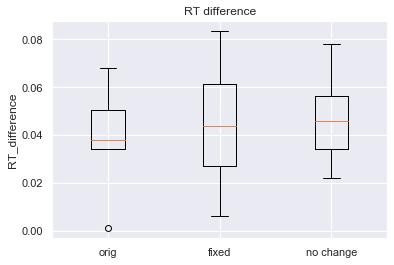

In [71]:
plt.boxplot([neg_RT_diff, pos_RT_diff, no_RT_diff])

plt.title('RT difference')
plt.xticks([1,2,3], labels = ['orig', 'fixed', 'no change'])
plt.ylabel('RT_difference')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_untar_tar_RT_diff_rt0.085.pdf',\
            bbox_inches='tight')

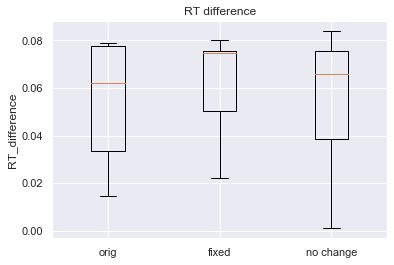

In [191]:
plt.boxplot([neg_RT_diff_3to5, pos_RT_diff_3to5, no_RT_diff_3to5])

plt.title('RT difference')
plt.xticks([1,2,3], labels = ['orig', 'fixed', 'no change'])
plt.ylabel('RT_difference')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_untar_tar_RT_diff_rt0.085_3to5.pdf',\
            bbox_inches='tight')

### Plot RT ranges of IS and drugs per strain

In [192]:
targeted_ms_paths = glob.glob(\
    'curated_input/targeted_per_strain/*_input_targeted_*')
targeted_perS_list_incl_RT = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                      for file in targeted_ms_paths]
del(targeted_ms_paths)

In [231]:
RT_ranges = []

for table in targeted_perS_list_incl_RT[:-4]:
    #table = targeted_perS_list_incl_RT[0]

    RT_cols = check_df.columns.str.endswith('RT')

    table_RT_vals = table.loc[:,RT_cols]
    
    #strain_ranges = []
    
    for row in table_RT_vals.index:
        range = np.nanmax(table_RT_vals.loc[row,:])-np.nanmin(table_RT_vals.loc[row,:])
        #strain_ranges.append(range)
        
        RT_ranges.append(range)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


[0.10400000000000009,
 0.04800000000000004,
 0.03499999999999992,
 0.06600000000000028,
 0.05700000000000016,
 0.0690000000000004,
 0.03699999999999992,
 0.0129999999999999,
 0.04800000000000004,
 0.07199999999999962,
 0.05899999999999972,
 0.07800000000000029,
 0.125,
 0.09199999999999964,
 0.025000000000000133,
 0.1460000000000008,
 0.15700000000000003,
 0.01200000000000001,
 0.02499999999999991,
 0.06800000000000139,
 0.08000000000000007,
 0.07699999999999996,
 0.05900000000000016,
 0.05699999999999994,
 0.07099999999999973,
 0.06600000000000028,
 0.06899999999999995,
 0.055999999999999606,
 0.0129999999999999,
 0.04900000000000038,
 0.01100000000000012,
 0.06100000000000039,
 0.05799999999999983,
 0.05799999999999983,
 0.09099999999999975,
 0.06499999999999995,
 0.0810000000000004,
 0.058000000000000274,
 0.05699999999999994,
 0.07000000000000028,
 0.0600000000000005,
 0.06799999999999962,
 0.06999999999999984,
 0.038000000000000034,
 0.06999999999999984,
 0.010999999999999677,
 0.

In [237]:

#plt.hist(RT_ranges[74], bins = 75, range = (0, 0.5))
#plt.bar(res, )
#plt.axvline(x=0.085)

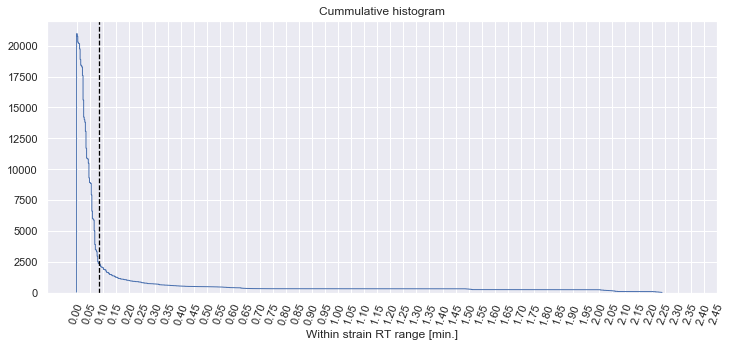

In [276]:

vals_only = [val for val in RT_ranges if not(np.isnan(val))]
xticks = np.arange(0, 2.5, 0.05)

plt.figure(figsize=[12,5])
plt.hist(vals_only, 1000, histtype="step", cumulative=-1)

plt.xticks(xticks, rotation = 70)
plt.axvline(x=0.085, color = 'black', ls = '--' , lw = 1.3)

plt.title('Cummulative histogram')
plt.xlabel('Within strain RT range [min.]')

plt.savefig('intermed_results/03_fix_missMerge/'+\
            today+'_tar_RT_ranges_0.085line.pdf',\
            bbox_inches='tight')

## Check examples in raw data

In [5]:
len(untargeted_perS_list)

77

In [37]:
test_df = untargeted_perS_list[24]

In [38]:
#354.1951
#425.7401

check_rows = test_df.loc[test_df['Mass'] > 425.738]
check_rows = check_rows.loc[check_rows['Mass'] < 425.741]

In [39]:
check_rows

MZ002H-Pool01-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                             31556.0   
425.7407@3.2518752                            263872.0   

                    MZ002H-Pool01-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                             36107.0   
425.7407@3.2518752                            252084.0   

                    MZ002H-Pool02-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                             60343.0   
425.7407@3.2518752                            278682.0   

                    MZ002H-Pool02-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                             33746.0   
425.7407@3.2518752                            278186.0   

                    MZ002H-Pool03-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                            208552.0   
425.7407@3.2518752                            228399.0   

                    MZ002H-Pool03-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                             35699.0   
425.7407@3.2518752                            239756.0   

                    MZ002H-Pool04-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                                 NaN   
425.7407@3.2518752                            237137.0   

                    MZ002H-Pool04-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                                 NaN   
425.7407@3.2518752                            246819.0   

                    MZ002H-Pool05-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                             42257.0   
425.7407@3.2518752                            261463.0   

                    MZ002H-Pool05-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                             59758.0   
425.7407@3.2518752                            268197.0   

                    MZ002H-Pool06-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                             26365.0   
425.7407@3.2518752                            243679.0   

                    MZ002H-Pool06-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                                 NaN   
425.7407@3.2518752                            260459.0   

                    MZ002H-Pool07-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                             52565.0   
425.7407@3.2518752                            241386.0   

                    MZ002H-Pool07-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                            201978.0   
425.7407@3.2518752                            255147.0   

                    MZ002H-Pool08-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                            231236.0   
425.7407@3.2518752                            232904.0   

                    MZ002H-Pool08-P003B4-S032-T12(raw)  \
Compound                                                 
425.7398@3.1587708                             38342.0   
425.7407@3.2518752                            268886.0   

                    MZ002H-Pool09-P003B4-S032-T00(raw)  \
Compound                                                 
425.7398@3.1587708                             32251.0   
425.7407@3.2518752                            245278.0   

                    MZ002H-Pool09-P003B4-S032-T12(raw)  \
C

In [41]:
check_rows.loc['425.7398@3.1587708','CompSpectrum']

'(874.4671, 2954.94)(875.4634, 2003.34)(426.7473, 18781.37)(427.7397, 2226.89)(428.7544, 62008.86)(429.7559, 6241.66)'

In [42]:
check_rows.loc['425.7407@3.2518752','CompSpectrum']

'(448.7295, 5505.52)(426.7482, 81549.59)(427.7503, 6141.79)(428.7464, 945.64)'